In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
# Faz download das imagens e cria um dataset para treinamento utilizando o utilitário tf.keras.utils.image_dataset_from_directory

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [ ]:
# Realiza a validação utilizando o utilitário tf.keras.utils.image_dataset_from_directory

In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [ ]:
# Mostra as primeiras nove imagens e rótulos do conjunto de treinamento:

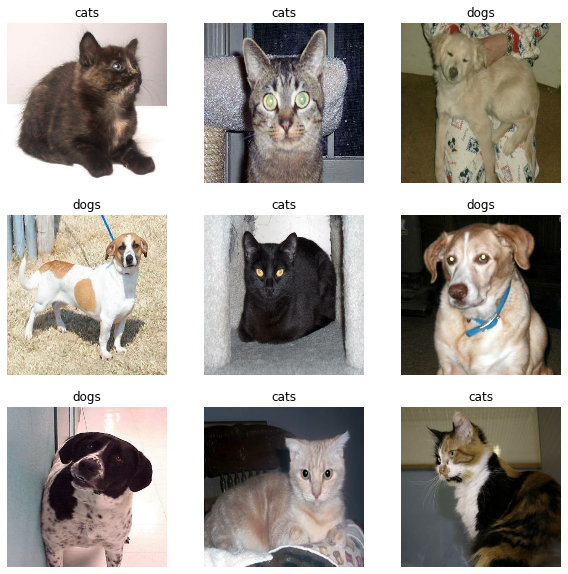

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Como o conjunto de dados original não contém um conjunto de teste, será criado um. 
# Para fazer isso, determine quantos lotes de dados estão disponíveis no conjunto de validação usando tf.data.experimental.cardinality 
# e mova 20% deles para um conjunto de teste (https://www.tensorflow.org/api_docs/python/tf/data/experimental/cardinality).

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
# Configura o conjunto de dados para desempenho
# Use a pré-busca em buffer para carregar imagens do disco sem que a E/S se torne um bloqueio. 
# Para saber mais sobre esse método, consulte o guia de desempenho de dados https://www.tensorflow.org/guide/data_performance 

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Quando não se tem um grande conjunto de dados de imagem, é uma boa prática introduzir artificialmente a diversidade de amostra
# aplicando transformações aleatórias, porém realistas, às imagens de treinamento, como rotação e inversão horizontal. Isso ajuda 
# a expor o modelo a diferentes aspectos dos dados de treinamento e reduzir o overfitting .

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
# Vamos aplicar repetidamente essas camadas na mesma imagem e ver o resultado.

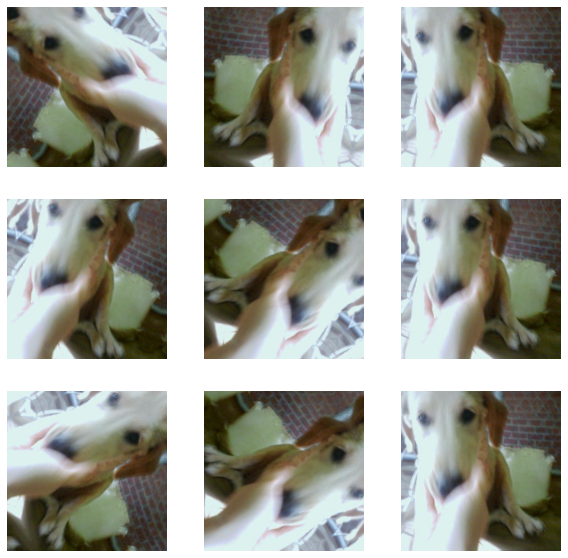

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
# Redimensionar valores de pixel
# tf.keras.applications.MobileNetV2 para uso como modelo base. Este modelo espera valores de pixel em [-1, 1] , mas neste ponto, 
# os valores de pixel em suas imagens estão em [0, 255] . Para redimensioná-los, use o método de pré-processamento incluído no modelo.

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Este extrator de recursos converte cada imagem de 160x160x3 em um bloco de recursos de 5x5x1280 . 
# Vamos ver o que ele faz com um exemplo de lote de imagens:

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
# Congele a base convolucional
# É importante congelar a base convolucional antes de compilar e treinar o modelo. O congelamento (definindo layer.trainable = False) 
# evita que os pesos em uma determinada camada sejam atualizados durante o treinamento. O MobileNet V2 tem muitas camadas, portanto, 
# definir o sinalizador trainable de todo o modelo como False irá congelar todas elas.

In [14]:
base_model.trainable = False

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
# Adiciona um cabeçalho de classificação
# Para gerar previsões a partir do bloco de feições, calcule a média das localizações espaciais 5x5 , 
# usando uma camada tf.keras.layers.GlobalAveragePooling2D para converter as feições em um único vetor de 1280 elementos por imagem.

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
# Aplica uma camada tf.keras.layers.Dense para converter esses recursos em uma única previsão por imagem. 
# Você não precisa de uma função de ativação aqui porque essa previsão será tratada como um logit ou um valor bruto de previsão. 
# Números positivos predizem a classe 1, números negativos predizem a classe 0.

In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
# Constroi um modelo encadeando as camadas de aumento de dados, redimensionamento, base_model e extrator de recursos usando a API funcional do Keras . 
# Use training=False pois nosso modelo contém uma camada BatchNormalization .

In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Compilar o modelo
# Compile o modelo antes de treiná-lo. Como existem duas classes, use a perda tf.keras.losses.BinaryCrossentropy com from_logits=True , pois o modelo fornece uma saída linear.

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
# Os 2,5 milhões de parâmetros no MobileNet estão congelados, mas existem 1,2 mil parâmetros treináveis na camada Dense. 
# Estes são divididos entre dois objetos tf.Variable , os pesos e os bias.

In [21]:
len(model.trainable_variables)

2

In [ ]:
# Treine o modelo
# Após treinar por 10 épocas, você deverá ver ~ 94% de precisão no conjunto de validação.

In [22]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 18s 581ms/step - loss: 0.9345 - accuracy: 0.4270


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.93
initial accuracy: 0.43


In [24]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 62s 922ms/step - loss: 0.7511 - accuracy: 0.5515 - val_loss: 0.5793 - val_accuracy: 0.6696
Epoch 2/10
63/63 [==============================] - 58s 919ms/step - loss: 0.5720 - accuracy: 0.6770 - val_loss: 0.4184 - val_accuracy: 0.8181
Epoch 3/10
63/63 [==============================] - 57s 910ms/step - loss: 0.4451 - accuracy: 0.7795 - val_loss: 0.3248 - val_accuracy: 0.8676
Epoch 4/10
63/63 [==============================] - 57s 906ms/step - loss: 0.3705 - accuracy: 0.8220 - val_loss: 0.2653 - val_accuracy: 0.8973
Epoch 5/10
63/63 [==============================] - 58s 920ms/step - loss: 0.3248 - accuracy: 0.8540 - val_loss: 0.2202 - val_accuracy: 0.9270
Epoch 6/10
63/63 [==============================] - 58s 900ms/step - loss: 0.2860 - accuracy: 0.8760 - val_loss: 0.1980 - val_accuracy: 0.9295
Epoch 7/10
63/63 [==============================] - 56s 885ms/step - loss: 0.2614 - accuracy: 0.8870 - val_loss: 0.1795 - val_accuracy: 0.9344

In [ ]:
# Curvas de aprendizado
# Vamos dar uma olhada nas curvas de aprendizado da precisão/perda de treinamento e validação ao usar o modelo base MobileNetV2 como um extrator de recursos fixo.

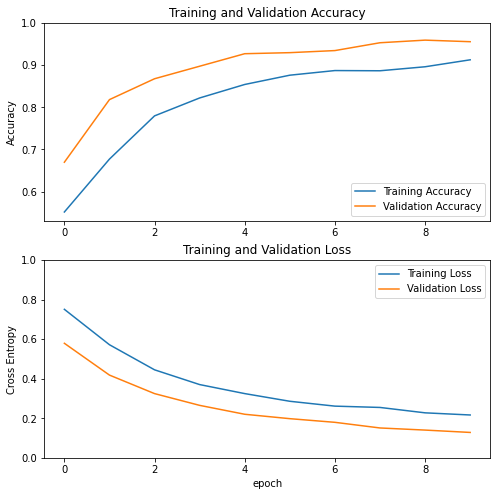

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Afinação
# Descongele as camadas superiores do modelo
# Decongele o base_model e definir as camadas inferiores como não treináveis. 
# Em seguida, recompile o modelo (necessário para que essas alterações tenham efeito) e retomar o treinamento.

In [26]:
base_model.trainable = True

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
# Compilar o modelo
# Como você está treinando um modelo muito maior e deseja readaptar os pesos pré-treinados, 
# é importante usar uma taxa de aprendizado menor neste estágio. Caso contrário, seu modelo pode se ajustar muito rapidamente.

In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [30]:
len(model.trainable_variables)

56

In [ ]:
# Continue treinando o modelo
# Se você treinou para convergência anteriormente, esta etapa melhorará sua precisão em alguns pontos percentuais.

In [31]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 97s 1s/step - loss: 0.1518 - accuracy: 0.9400 - val_loss: 0.0811 - val_accuracy: 0.9740
Epoch 11/20
63/63 [==============================] - 95s 2s/step - loss: 0.1244 - accuracy: 0.9490 - val_loss: 0.0513 - val_accuracy: 0.9827
Epoch 12/20
63/63 [==============================] - 93s 1s/step - loss: 0.1047 - accuracy: 0.9580 - val_loss: 0.0544 - val_accuracy: 0.9814
Epoch 13/20
63/63 [==============================] - 90s 1s/step - loss: 0.1007 - accuracy: 0.9605 - val_loss: 0.0368 - val_accuracy: 0.9876
Epoch 14/20
63/63 [==============================] - 87s 1s/step - loss: 0.1032 - accuracy: 0.9550 - val_loss: 0.0471 - val_accuracy: 0.9864
Epoch 15/20
63/63 [==============================] - 86s 1s/step - loss: 0.0751 - accuracy: 0.9690 - val_loss: 0.0452 - val_accuracy: 0.9889
Epoch 16/20
63/63 [==============================] - 86s 1s/step - loss: 0.0828 - accuracy: 0.9665 - val_loss: 0.0303 - val_accuracy: 0.9889
Epoch 17/20
6

In [ ]:
# Você também pode ter algum overfitting, pois o novo conjunto de treinamento é relativamente pequeno e semelhante aos conjuntos de dados originais do MobileNetV2.
# Após o ajuste fino, o modelo atinge quase 98% de precisão no conjunto de validação.

In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

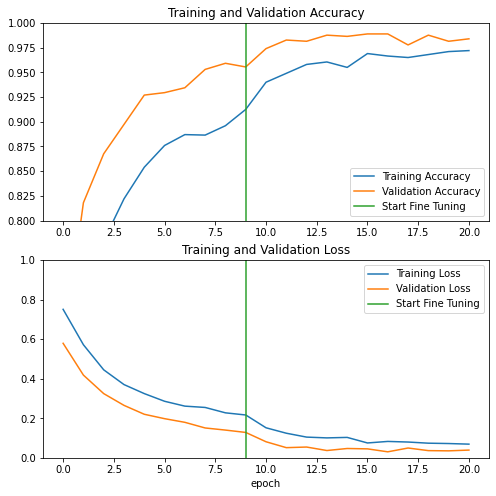

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Avaliação e previsão
# Finalmente, você pode verificar o desempenho do modelo em novos dados usando o conjunto de teste.

In [34]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 4s 577ms/step - loss: 0.0531 - accuracy: 0.9792
Test accuracy : 0.9791666865348816


Predictions:
 [0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 1 1 1]
Labels:
 [0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1]


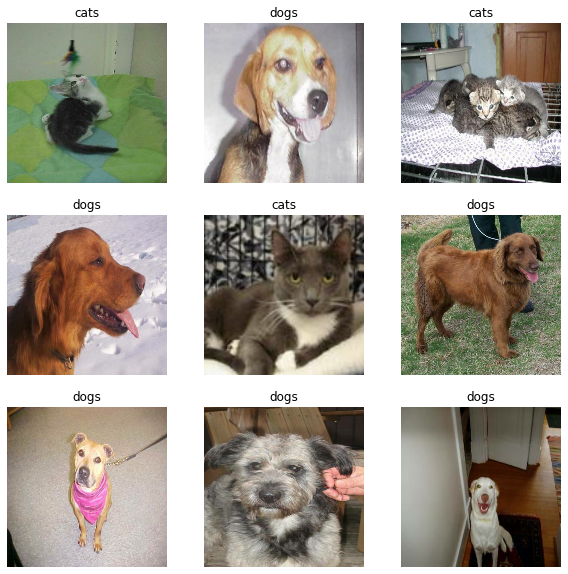

In [35]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")